In [804]:
import matplotlib.pyplot as plt
from mdptoolbox import mdp
import numpy as np
from tqdm import tqdm
import os
import contextlib

In [4]:
def getMarkov(alpha1, alpha2):
    res = np.zeros((5,5))
    for i in [1,2,3]:
        res[i, i-1] = alpha2
        res[i, i+1] = alpha1
    res[0] = [0, alpha1, alpha2, 0, 0]
    res[4] = [0, 0, alpha1, alpha2, 0]
    return res

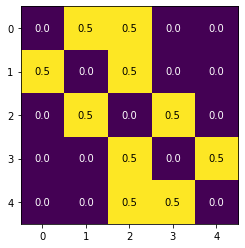

In [23]:
res = getMarkov(0.5,0.5)

f, ax = plt.subplots(figsize=(4,4))
ax.imshow(res)
for (j,i),label in np.ndenumerate(res):
    if label < 0.5:
        ax.text(i,j,label,ha='center',va='center', color='white')
    else:
        ax.text(i,j,label,ha='center',va='center', color='black')

In [24]:
state = np.array([0,0,1,0,0])
for _ in range(1000):
    state = np.matmul(state, res)
state

array([0.11111111, 0.22222222, 0.33333333, 0.22222222, 0.11111111])

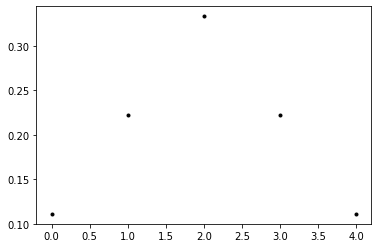

In [25]:
plt.plot(state, 'k.')

# MDP

In [42]:
class States:
    def __init__(self, k):
        self.states = []
        for i in range(k+1):
            for j in range(k+1):
                self.states.append((i,j))
    
    def getState(self, ind):
        return self.states[ind]

    def getInd(self, state):
        return self.states.index(state)

In [198]:
def getAdopt(alpha, k):
    states = States(k)
    adoptTransitions = np.zeros(((k+1)**2, (k+1)**2))
    adoptRewards = np.zeros(((k+1)**2, (k+1)**2))
    ind00 = states.getInd((0,0))
    ind01 = states.getInd((0,1))
    for i in range((k+1)**2):
        adoptTransitions[i,ind00] = alpha
        adoptRewards[i,ind00] = 1
        adoptTransitions[i,ind01] = 1-alpha
    return adoptTransitions, adoptRewards

def getWait(alpha, k, W=1):
    states = States(k)
    waitTransitions = np.zeros(((k+1)**2, (k+1)**2))
    waitRewards = np.zeros(((k+1)**2, (k+1)**2))
    for a in range(k+1):
        for h in range(k+1):
            try:
                cur_ind = states.getInd((a,h))
                if a < h:
                    ap1h = states.getInd((a+1,h))
                    ahp1 = states.getInd((a,h+1))
                    waitTransitions[cur_ind, ap1h] = alpha
                    waitTransitions[cur_ind, ahp1] = 1 - alpha
                elif a == h:
                    ind00 = states.getInd((0,0))
                    ahp1 = states.getInd((a,h+1))
                    waitTransitions[cur_ind, ind00] = alpha
                    waitRewards[cur_ind, ind00] = W+h+1
                    waitTransitions[cur_ind, ahp1] = 1 - alpha
                else:
                    ind00 = states.getInd((0,0))
                    waitTransitions[cur_ind, ind00] = 1
                    waitRewards[cur_ind, ind00] = -1
            except ValueError:
                waitTransitions[cur_ind, ind00] = 1
                waitRewards[cur_ind, ind00] = -1
    return waitTransitions, waitRewards

In [461]:
k=10
alpha = 0.4
adoptTransitions, adoptRewards = getAdopt(alpha, k)
waitTransitions, waitRewards = getWait(alpha, k, W=100)

In [462]:
transitions = np.stack((adoptTransitions, waitTransitions))
rewards = np.stack((adoptRewards, waitRewards))
transitions.shape, rewards.shape

((2, 121, 121), (2, 121, 121))

In [463]:
res = mdp.ValueIteration(transitions, rewards, discount=1)
res.run()

In [464]:
res

P: 
array([[0.4, 0.6, 0. , ..., 0. , 0. , 0. ],
       [0.4, 0.6, 0. , ..., 0. , 0. , 0. ],
       [0.4, 0.6, 0. , ..., 0. , 0. , 0. ],
       ...,
       [0.4, 0.6, 0. , ..., 0. , 0. , 0. ],
       [0.4, 0.6, 0. , ..., 0. , 0. , 0. ],
       [0.4, 0.6, 0. , ..., 0. , 0. , 0. ]])
array([[0.4, 0.6, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.6, ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [1. , 0. , 0. , ..., 0. , 0. , 0. ]])

R: 
array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
     

In [465]:
states = States(k)
opt_policy = np.zeros((k+1,k+1))
for i in range(len(res.policy)):
    cur_state = states.getState(i)
    if cur_state[0] <= cur_state[1]: 
        opt_policy[cur_state] = res.policy[i]

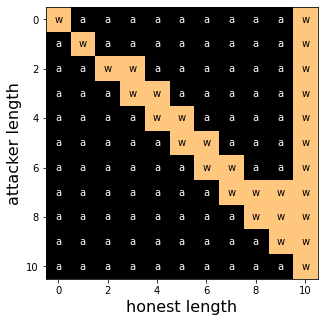

In [466]:
f, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(opt_policy, origin='upper', cmap='copper')
ax.set_xlabel('honest length', size=16)
ax.set_ylabel('attacker length', size=16)

for (j,i),label in np.ndenumerate(opt_policy):
    if label < 0.5:
        ax.text(i,j,'a',ha='center',va='center', color='white')
    else:
        ax.text(i,j,'w',ha='center',va='center', color='black')

plt.show()

In [318]:
states.getInd((3,4)), res.policy[58]

(58, 1)

# Finite horizon

In [473]:
class States:
    def __init__(self, k):
        self.states = []
        for i in range(k+1):
            for j in range(k+1):
                self.states.append((i,j))
                
        self.states.append((-1,-1))
    
    def getState(self, ind):
        return self.states[ind]

    def getInd(self, state):
        return self.states.index(state)

In [581]:
def getAdopt(alpha, k):
    states = States(k)
    # initialize transition and reward matrices
    adoptTransitions = np.zeros(((k+1)**2+1, (k+1)**2+1))
    adoptRewards = np.zeros(((k+1)**2+1, (k+1)**2+1))

    # get index of sink state
    indm1m1 = states.getInd((-1,-1))
    for a in range(k+1):
        for h in range(k+1):
            cur_ind = states.getInd((a,h))
            adoptTransitions[cur_ind,indm1m1] = 1
            adoptRewards[cur_ind,indm1m1] = -a

    # sink state
    adoptTransitions[indm1m1, indm1m1] = 1
    return adoptTransitions, adoptRewards

def getWait(alpha, k, W=1):
    states = States(k)
    waitTransitions = np.zeros(((k+1)**2+1, (k+1)**2+1))
    waitRewards = np.zeros(((k+1)**2+1, (k+1)**2+1))
    
    # get index of sink state
    indm1m1 = states.getInd((-1,-1))
    
    for a in range(k+1):
        for h in range(k+1):
            try:
                cur_ind = states.getInd((a,h))
                if a < h:
                    ap1h = states.getInd((a+1,h))
                    ahp1 = states.getInd((a,h+1))
                    waitTransitions[cur_ind, ap1h] = alpha
                    waitTransitions[cur_ind, ahp1] = 1 - alpha
                elif a == h:
                    ahp1 = states.getInd((a,h+1))
                    waitTransitions[cur_ind, indm1m1] = alpha
                    waitRewards[cur_ind, indm1m1] = W
                    waitTransitions[cur_ind, ahp1] = 1 - alpha
                else:
                    ind00 = states.getInd((0,0))
                    waitTransitions[cur_ind, indm1m1] = 1
                    waitRewards[cur_ind, indm1m1] = -1000
            except ValueError:
                waitTransitions[cur_ind, indm1m1] = 1
                waitRewards[cur_ind, indm1m1] = -1000
    # sink state
    waitTransitions[indm1m1, indm1m1] = 1
    return waitTransitions, waitRewards

def getTerminalRewards(k):
    states = States(k)
    terminalRewards = np.zeros((k+1)**2+1)
    for a in range(k+1):
        for h in range(k+1):
            cur_ind = states.getInd((a,h))
            terminalRewards[cur_ind] = -a
    return terminalRewards

In [669]:
k=10
alpha = 0.4
adoptTransitions, adoptRewards = getAdopt(alpha, k)
waitTransitions, waitRewards = getWait(alpha, k, W=1)

In [670]:
transitions = np.stack((adoptTransitions, waitTransitions))
rewards = np.stack((adoptRewards, waitRewards))
transitions.shape, rewards.shape

((2, 122, 122), (2, 122, 122))

In [671]:
terminal_rewards = getTerminalRewards(k)

In [672]:
res = mdp.FiniteHorizon(transitions, rewards, discount=1, N=100, h=terminal_rewards)
res.run()

In [673]:
res.policy[-1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [674]:
policy_id = 93
states = States(k)
opt_policy = np.zeros((k+1,k+1))
for i in range(len(res.policy[:,policy_id])):
    cur_state = states.getState(i)
    if cur_state[0] <= cur_state[1]: 
        opt_policy[cur_state] = res.policy[:,policy_id][i]

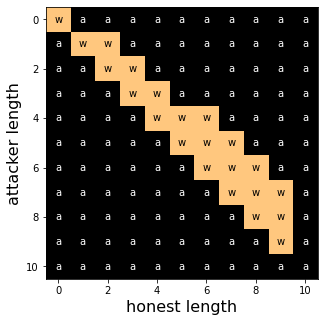

In [675]:
f, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(opt_policy, origin='upper', cmap='copper')
ax.set_xlabel('honest length', size=16)
ax.set_ylabel('attacker length', size=16)

for (j,i),label in np.ndenumerate(opt_policy):
    if label < 0.5:
        ax.text(i,j,'a',ha='center',va='center', color='white')
    else:
        ax.text(i,j,'w',ha='center',va='center', color='black')

plt.show()

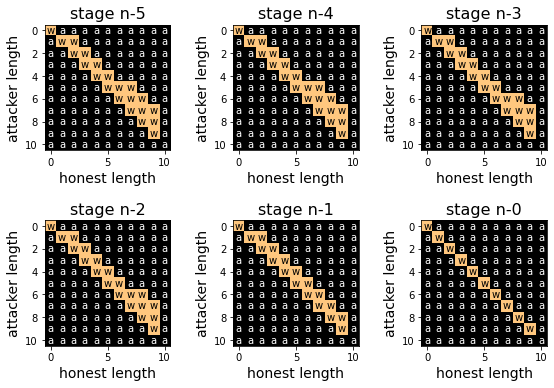

In [676]:
f, axarr = plt.subplots(figsize=(9,6), nrows=2, ncols=3)
for ind, policy_id in enumerate([94,95,96,97,98,99]):
    states = States(k)
    opt_policy = np.zeros((k+1,k+1))
    for i in range(len(res.policy[:,policy_id])):
        cur_state = states.getState(i)
        if cur_state[0] <= cur_state[1]: 
            opt_policy[cur_state] = res.policy[:,policy_id][i]
    
    axarr[int(ind//3), int(ind%3)].imshow(opt_policy, origin='upper', cmap='copper')
    for (j,i),label in np.ndenumerate(opt_policy):
        if label < 0.5:
            axarr[int(ind//3), int(ind%3)].text(i,j,'a',ha='center',va='center', color='white')
        else:
            axarr[int(ind//3), int(ind%3)].text(i,j,'w',ha='center',va='center', color='black')
    axarr[int(ind//3), int(ind%3)].set_title('stage n-{}'.format(6-ind-1), size=16)

for ax in axarr.flatten():
    ax.set_xlabel('honest length', size=14)
    ax.set_ylabel('attacker length', size=14)
f.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

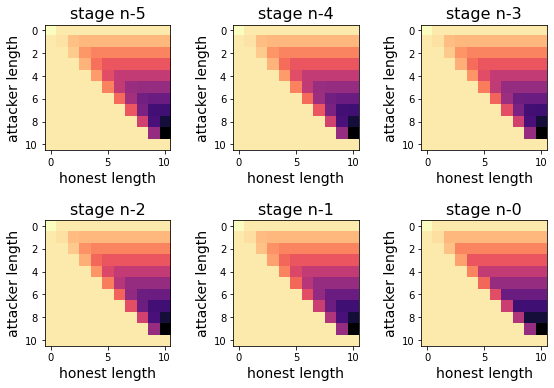

In [677]:
f, axarr = plt.subplots(figsize=(9,6), nrows=2, ncols=3)
for ind, policy_id in enumerate([94,95,96,97,98,99]):
    states = States(k)
    opt_policy = np.zeros((k+1,k+1))
    for i in range(len(res.V[:,policy_id])):
        cur_state = states.getState(i)
        if cur_state[0] <= cur_state[1]: 
            opt_policy[cur_state] = res.V[:,policy_id][i]
    
    axarr[int(ind//3), int(ind%3)].imshow(opt_policy, origin='upper', cmap='magma')
    axarr[int(ind//3), int(ind%3)].set_title('stage n-{}'.format(6-ind-1), size=16)

for ax in axarr.flatten():
    ax.set_xlabel('honest length', size=14)
    ax.set_ylabel('attacker length', size=14)
f.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

In [667]:
res.V[0,0]

61.69516414700219

In [668]:
opt_policy[0,0]

40.0

In [678]:
def getPoliciesValues(k, alpha, W):
    adoptTransitions, adoptRewards = getAdopt(alpha, k)
    waitTransitions, waitRewards = getWait(alpha, k, W)

    transitions = np.stack((adoptTransitions, waitTransitions))
    rewards = np.stack((adoptRewards, waitRewards))
    terminal_rewards = getTerminalRewards(k)

    res = mdp.FiniteHorizon(transitions, rewards, discount=1, N=100, h=terminal_rewards)
    res.run()
    
    states = States(k)
    policies = []
    for policy_id in range(100):
        opt_policy = np.zeros((k+1,k+1))
        for i in range(len(res.policy[:,policy_id])):
            cur_state = states.getState(i)
            if cur_state[0] <= cur_state[1]: 
                opt_policy[cur_state] = res.policy[:,policy_id][i]
        policies.append(opt_policy)

    values = []
    for policy_id in range(100):
        opt_vals = np.zeros((k+1,k+1))
        for i in range(len(res.V[:,policy_id])):
            cur_state = states.getState(i)
            if cur_state[0] <= cur_state[1]: 
                opt_vals[cur_state] = res.V[:,policy_id][i]
        values.append(opt_vals)

    return np.asarray(policies), np.asarray(values)

In [722]:
policies, values = getPoliciesValues(k=10, alpha=0.4, W=0.1)

In [723]:
policies.shape, values.shape

((100, 11, 11), (100, 11, 11))

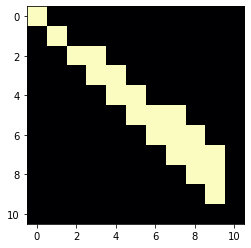

In [724]:
plt.imshow(policies[0], cmap='magma')

In [725]:
values[0][0,0]

0.04000000000000001

In [726]:
# alpha = 0.4
opt_vals = []
for W in np.linspace(0, 2, 40):
    policies, values = getPoliciesValues(k=10, alpha=0.4, W=W)
    opt_vals.append(values[0][0,0])
opt_vals = np.asarray(opt_vals)

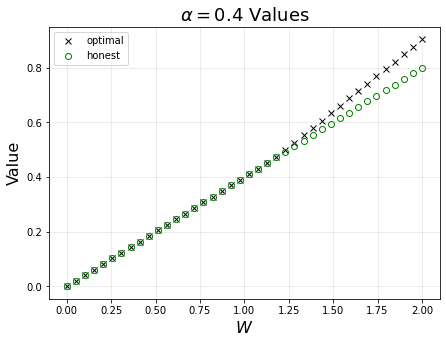

In [735]:
f, ax = plt.subplots(figsize=(7,5))

Ws = np.linspace(0, 2, 40)
ax.plot(Ws, opt_vals, 'x', color='k', label='optimal')
ax.plot(Ws, Ws*alpha, 'o', color='g', fillstyle='none', label='honest')

ax.set_xlabel(r'$W$', size=16)
ax.set_ylabel('Value', size=16)
ax.set_title(r'$\alpha=0.4$ Values', size=18)

ax.grid(alpha=0.3)
ax.legend()
plt.show()

In [778]:
# many alphas
alphas = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
Ws = [4, 3, 3, 2, 2, 1]
results = []
for i, alpha in enumerate(alphas):
    opt_vals = []
    upperW = Ws[i]
    for W in np.linspace(0, 5, 30):
        policies, values = getPoliciesValues(k=10, alpha=alpha, W=W)
        opt_vals.append(values[0][0,0])
    results.append(opt_vals)
results = np.asarray(results)

In [768]:
results.shape

(6, 40)

In [781]:
xw

array([0.        , 0.17241379, 0.34482759, 0.51724138, 0.68965517,
       0.86206897, 1.03448276, 1.20689655, 1.37931034, 1.55172414,
       1.72413793, 1.89655172, 2.06896552, 2.24137931, 2.4137931 ,
       2.5862069 , 2.75862069, 2.93103448, 3.10344828, 3.27586207,
       3.44827586, 3.62068966, 3.79310345, 3.96551724, 4.13793103,
       4.31034483, 4.48275862, 4.65517241, 4.82758621, 5.        ])

In [782]:
results[i] > xw * 0.2

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

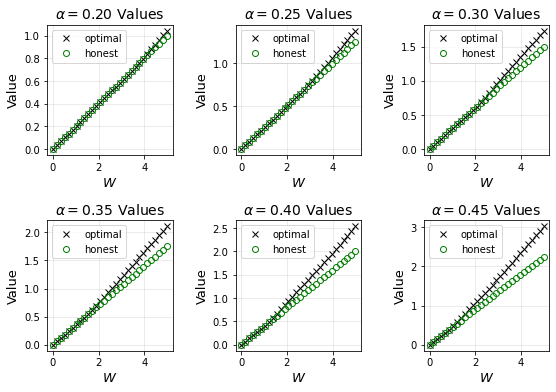

In [779]:
f, axarr = plt.subplots(figsize=(9,6), ncols=3, nrows=2)

for i, alpha in enumerate(alphas):
    opt_vals = []
    upperW = Ws[i]
    xw = np.linspace(0, 5, 30)
    axarr[int(i//3), int(i%3)].plot(xw, results[i], 'x', color='k', label='optimal')
    axarr[int(i//3), int(i%3)].plot(xw, xw*alpha, 'o', color='g', fillstyle='none', label='honest')

for i, ax in enumerate(axarr.flatten()):
    ax.set_xlabel(r'$W$', size=13)
    ax.set_ylabel('Value', size=13)
    ax.set_title(r'$\alpha=${:0.2f} Values'.format(alphas[i]), size=14)

    ax.grid(alpha=0.3)
    ax.legend()
    
f.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

# dishonest point

In [790]:
alpha = 0.01
W = 99
policies, values = getPoliciesValues(k=10, alpha=alpha, W=W)
values[0][0,0], policies[0][0,1]

(0.9900009997980104, 1.0)

In [816]:
alphas = np.arange(0.1, 0.491, 0.01)
Ws = np.arange(0, 100, 0.01)
results = []
for alpha in tqdm(alphas):
    for W in Ws:
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            policies, values = getPoliciesValues(k=10, alpha=alpha, W=W)
        if values[0][0,0] > W * alpha:
            assert(policies[0][0,1] == 1)
            results.append(W)
            break
results = np.asarray(results)

100%|██████████| 40/40 [03:23<00:00,  5.09s/it]


In [817]:
results

array([8.91, 7.99, 7.22, 6.57, 6.01, 5.53, 5.1 , 4.72, 4.39, 4.09, 3.81,
       3.57, 3.34, 3.14, 2.95, 2.77, 2.61, 2.46, 2.32, 2.19, 2.07, 1.96,
       1.85, 1.75, 1.66, 1.57, 1.48, 1.4 , 1.33, 1.26, 1.19, 1.12, 1.06,
       1.  , 0.95, 0.89, 0.84, 0.79, 0.74, 0.69])

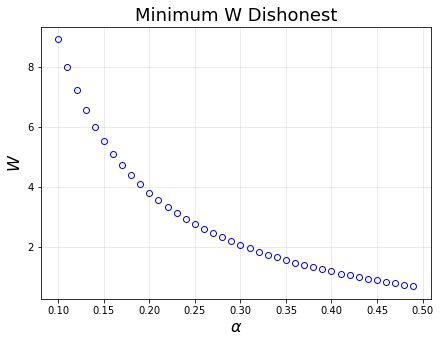

In [821]:
f, ax = plt.subplots(figsize=(7,5))

ax.plot(alphas, results, 'o', fillstyle='none', color='b')
ax.set_xlabel(r'$\alpha$', size=16)
ax.set_ylabel(r'$W$', size=16)
ax.set_title('Minimum W Dishonest', size=18)
ax.grid(alpha=0.3)

plt.show()

# Three player

In [850]:
alpha = 1/3
W = 2
policies, values = getPoliciesValues(k=10, alpha=alpha, W=W)
values[0][0,0], policies[0][0,1]

(0.6938763822925568, 1.0)

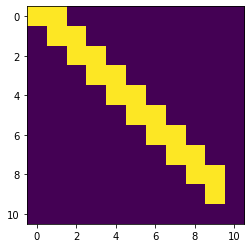

In [851]:
plt.imshow(policies[0])

In [852]:
class States3:
    def __init__(self, k):
        self.states = []
        for i in range(k+1):
            for j in range(k+1):
                for j2 in range(k+1):
                    self.states.append((i,j, j2))
        self.states.append((-1,-1,-1))
    
    def getState(self, ind):
        return self.states[ind]

    def getInd(self, state):
        return self.states.index(state)

In [854]:
states = States3(2)
states.states

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (-1, -1, -1)]

In [869]:
def getAdopt(alpha, k):
    states = States3(k)
    # initialize transition and reward matrices
    adoptTransitions = np.zeros(((k+1)**3+1, (k+1)**3+1))
    adoptRewards = np.zeros(((k+1)**3+1, (k+1)**3+1))

    # get index of sink state
    indm1m1 = states.getInd((-1,-1,-1))
    for a1 in range(k+1):
        for a2 in range(k+1):
            for a3 in range(k+1):
                cur_ind = states.getInd((a1,a2,a3))
                adoptTransitions[cur_ind,indm1m1] = 1
                adoptRewards[cur_ind,indm1m1] = -a1

    # sink state
    adoptTransitions[indm1m1, indm1m1] = 1
    return adoptTransitions, adoptRewards

In [870]:
a_transitions, a_rewards = getAdopt(1/3, 2)

In [950]:
def getWait(alphas, k, W=1):
    alpha1, alpha2, alpha3 = alphas
    states = States3(k)
    waitTransitions = np.zeros(((k+1)**3+1, (k+1)**3+1))
    waitRewards = np.zeros(((k+1)**3+1, (k+1)**3+1))
    
    # get index of sink state
    indm1m1 = states.getInd((-1,-1,-1))
    
    for a1 in range(k+1):
        for a2 in range(k+1):
            for a3 in range(k+1):
                try:
                    cur_ind = states.getInd((a1,a2,a3))
                    if (a1 - a2 >= 2) or (a1 - a3 >= 2):
                        waitTransitions[cur_ind, indm1m1] = 1
                        waitRewards[cur_ind, indm1m1] = W
                    elif (abs(a2 - a3) <= 1):
                        a1p1 = states.getInd((a1+1, a2, a3))
                        a2p1 = states.getInd((a1, a2+1, a3))
                        a3p1 = states.getInd((a1, a2, a3+1))
                        waitTransitions[cur_ind, a1p1] = alpha1
                        waitTransitions[cur_ind, a2p1] = alpha2
                        waitTransitions[cur_ind, a3p1] = alpha3
                    elif (a2 - a3 >= 2):
                        a1p1 = states.getInd((a1+1, a2, a3))
                        a2p1 = states.getInd((a1, a2+1, a3))
                        waitTransitions[cur_ind, a1p1] = alpha1
                        waitTransitions[cur_ind, a2p1] = alpha2 + alpha3
                    elif (a3 - a2 >= 2):
                        a1p1 = states.getInd((a1+1, a2, a3))
                        a3p1 = states.getInd((a1, a2, a3+1))
                        waitTransitions[cur_ind, a1p1] = alpha1
                        waitTransitions[cur_ind, a3p1] = alpha2 + alpha3
                    
    
                except ValueError:
                    waitTransitions[cur_ind, indm1m1] = 1
                    waitRewards[cur_ind, indm1m1] = -1000
    # sink state
    waitTransitions[indm1m1, indm1m1] = 1
    return waitTransitions, waitRewards

In [957]:
alphas = (1/3, 1/3, 1/3)
w_transitions, w_rewards = getWait(alphas, k=2, W=2)

In [958]:
processTransitionsRewards(w_transitions, w_rewards, k=2)

(0, 0, 0)
  -> (0, 0, 1) w.p. 0.33, rew=0.0
  -> (0, 1, 0) w.p. 0.33, rew=0.0
  -> (1, 0, 0) w.p. 0.33, rew=0.0
(0, 0, 1)
  -> (0, 0, 2) w.p. 0.33, rew=0.0
  -> (0, 1, 1) w.p. 0.33, rew=0.0
  -> (1, 0, 1) w.p. 0.33, rew=0.0
(0, 0, 2)
  -> (-1, -1, -1) w.p. 1.00, rew=-1000.0
(0, 1, 0)
  -> (0, 1, 1) w.p. 0.33, rew=0.0
  -> (0, 2, 0) w.p. 0.33, rew=0.0
  -> (1, 1, 0) w.p. 0.33, rew=0.0
(0, 1, 1)
  -> (0, 1, 2) w.p. 0.33, rew=0.0
  -> (0, 2, 1) w.p. 0.33, rew=0.0
  -> (1, 1, 1) w.p. 0.33, rew=0.0
(0, 1, 2)
  -> (-1, -1, -1) w.p. 1.00, rew=-1000.0
(0, 2, 0)
  -> (-1, -1, -1) w.p. 1.00, rew=-1000.0
(0, 2, 1)
  -> (-1, -1, -1) w.p. 1.00, rew=-1000.0
(0, 2, 2)
  -> (-1, -1, -1) w.p. 1.00, rew=-1000.0
(1, 0, 0)
  -> (1, 0, 1) w.p. 0.33, rew=0.0
  -> (1, 1, 0) w.p. 0.33, rew=0.0
  -> (2, 0, 0) w.p. 0.33, rew=0.0
(1, 0, 1)
  -> (1, 0, 2) w.p. 0.33, rew=0.0
  -> (1, 1, 1) w.p. 0.33, rew=0.0
  -> (2, 0, 1) w.p. 0.33, rew=0.0
(1, 0, 2)
  -> (-1, -1, -1) w.p. 1.00, rew=-1000.0
(1, 1, 0)
  -> (1, 1, 

In [945]:
def processTransitionsRewards(transitions, rewards, k):
    states = States3(k)
    for i in range(len(transitions)):
        cur_tr = transitions[i]
        next_states = []
        for j in range(len(cur_tr)):
            if cur_tr[j] != 0:
                next_states.append((j, cur_tr[j], rewards[i,j]))
        cur_state = states.getState(i)
        print('{}'.format(cur_state))
        for k in range(len(next_states)):
            next_state = states.getState(next_states[k][0])
            next_prob = next_states[k][1]
            reward = next_states[k][2]
            print('  -> {} w.p. {:0.2f}, rew={}'.format(next_state, next_prob,reward))

In [911]:
def getTerminalRewards(k):
    states = States3(k)
    terminalRewards = np.zeros((k+1)**3+1)
    for a1 in range(k+1):
        for a2 in range(k+1):
            for a3 in range(k+1):
                cur_ind = states.getInd((a1,a2,a3))
                terminalRewards[cur_ind] = -a1
    return terminalRewards

In [953]:
alpha = 1/3
alphas = (1/3,1/3,1/3)

k = 2
W = 2

In [954]:
adoptTransitions, adoptRewards = getAdopt(alpha, k)
waitTransitions, waitRewards = getWait(alphas, k, W)
transitions = np.stack((adoptTransitions, waitTransitions))
rewards = np.stack((adoptRewards, waitRewards))
terminal_rewards = getTerminalRewards(k)

In [926]:
res = mdp.FiniteHorizon(transitions, rewards, discount=1, N=100, h=terminal_rewards)
res.run()

In [929]:
res.policy.shape

(28, 100)

In [935]:
def getPoliciesValues3(k, alpha, W):
    adoptTransitions, adoptRewards = getAdopt(alpha, k)
    waitTransitions, waitRewards = getWait((alpha, alpha, alpha), k, W)

    transitions = np.stack((adoptTransitions, waitTransitions))
    rewards = np.stack((adoptRewards, waitRewards))
    terminal_rewards = getTerminalRewards(k)

    res = mdp.FiniteHorizon(transitions, rewards, discount=1, N=100, h=terminal_rewards)
    res.run()
    
    states = States3(k)
    policies = []
    for policy_id in range(100):
        opt_policy = np.zeros((k+1,k+1,k+1))
        for i in range(len(res.policy[:,policy_id])):
            cur_state = states.getState(i)
            if cur_state[0] <= cur_state[1]: 
                opt_policy[cur_state] = res.policy[:,policy_id][i]
        policies.append(opt_policy)

    values = []
    for policy_id in range(100):
        opt_vals = np.zeros((k+1,k+1,k+1))
        for i in range(len(res.V[:,policy_id])):
            cur_state = states.getState(i)
            if cur_state[0] <= cur_state[1]: 
                opt_vals[cur_state] = res.V[:,policy_id][i]
        values.append(opt_vals)

    return np.asarray(policies), np.asarray(values)

In [967]:
policies, values = getPoliciesValues3(k=3, alpha=1/3, W=1)
policies.shape

(100, 4, 4, 4)

In [968]:
policies[0], values[0]

(array([[[1., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],
 
        [[0., 0., 0., 0.],
         [1., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 0.]],
 
        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [1., 1., 0., 0.],
         [1., 0., 0., 0.]],
 
        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [1., 1., 0., 0.]]]),
 array([[[ 0.10288066,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ]],
 
        [[ 0.        ,  0.        ,  0.        ,  0.        ],
         [-0.03703704, -0.77777778, -1.        , -1.        ],
         [-0.33333333, -1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        , -1.        ]],
 
        [[ 0.        ,  0.        ,  0.       